# Imports and Defaults

In [34]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from persim import gromov_hausdorff
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

In [53]:
data_path = './data/mdbs/'
save_path = '../writeup/images/q8'
seed = 0
rng = np.random.default_rng(seed=seed)
plt.style.use('seaborn')

/var/folders/sm/j_xxwpn91bb8wdfzfy3mn5600000gn/T/ipykernel_25762/2308263298.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Gromov-Hausdorff Metric

In [58]:
def load_data(data_path):
    files = os.listdir(data_path)
    
    point_cloud_dataset = []
    for tooth in files:
        mat = scipy.io.loadmat(f'{data_path}/{tooth}')
        datapoint = mat["Mdb1"][0][0][11]
        point_cloud_dataset.append(datapoint)
    return np.asarray(point_cloud_dataset, dtype=object)

def subsample(X, n_subsample):
    X_sub = np.zeros((X.shape[0], n_subsample, 3)) # [n_samples X n_subsample X n_features]
    
    # iterate over all point clouds in X
    for i, x in enumerate(X):
        idx = rng.integers(low=0, high=x.shape[0], size=n_subsample) # subsample indices
        X_sub[i] = x[idx]
    return X_sub

In [59]:
def gramov_hausdorff_dist(X):
    n = X.shape[0]
    n_neighbors = 10

    dist = np.zeros((n, n))
    for i in tqdm(range(n)):
        adj_i = kneighbors_graph(X[i], n_neighbors=n_neighbors, n_jobs=-1).toarray()
        for j in range(i+1, n):
            adj_j = kneighbors_graph(X[j], n_neighbors=n_neighbors, n_jobs=-1).toarray()
            
            lower_bound, upper_bound = gromov_hausdorff(adj_i, adj_j)
            dist[i,j] = (lower_bound + upper_bound) / 2
            dist[j,i] = dist[i,j]
    return dist

In [60]:
def plot(X, labels, n_clusters):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i in range(n_clusters):
        idx = np.where(labels==i)
        ax.scatter3D(X[idx, :, 0], X[idx, :, 1], X[idx, :, 2], marker='.', label=f'Cluster {i}')
    ax.legend()
    
    fname = os.path.join(save_path, 'gromov_hausdorff_clusters.png')
    fig.savefig(fname)

100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


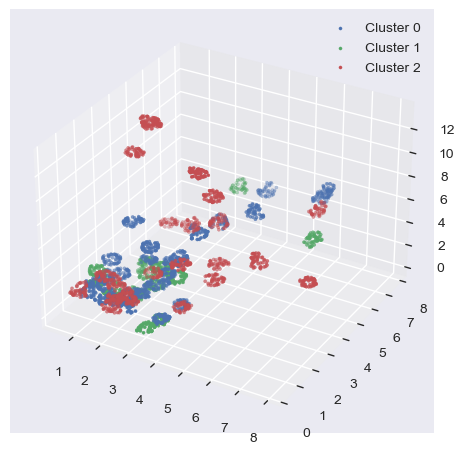

In [61]:
n_subsample = 50
n_clusters = 3 # project into 3d space

X = load_data(data_path)
X = subsample(X, n_subsample)
D = gramov_hausdorff_dist(X)
labels = SpectralClustering(n_clusters=n_clusters, affinity='precomputed',
                            random_state=seed).fit(D).labels_
plot(X, labels, n_clusters)